<a href="https://colab.research.google.com/github/abbyWoot/AML/blob/master/AML_BinarizedMnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 6 - Team 2
Joe, Getong, Abby

In this project, the following items were performed.

1) 4 Datasets: binarized_mnist, AFLW2000-3D

2) For each dataset, cluster the images using K-Means and plot the elbow graph to show the best K.

3) Train a classifier to determine which object is represented in each image and evaluate it on the validation set.

4) Use K-Means as a dimensionality reduction tool and train a classifier on the reduced set. Search for the number of clusters that provides the best performance.

5) Train a Gaussian mixture model  on each dataset. To speed up the algorithm, use PCA dimensionality reduction (99% variataion).

6) Graph results of your experiments for the different data sets and provide a qualitative assessment and detailed discussion of the achieved results.


#**Binarized Mnist**
binarized_mnist: A specific binarization of the MNIST images originally used in (Salakhutdinov & Murray, 2008). This dataset is frequently used to evaluate generative models of images, so labels are not provided.
Scale 28x 28 X 1:  28 X 28 is the size of each image. 1 is the number of channels of the image. Black and white images have 1 channel.



# Setup

In [0]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import urllib
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.mixture import GaussianMixture

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# DatasetBuilder

In [0]:
import tensorflow as tf
import tensorflow_datasets as tfds

# SPLITS
split_labels = ["train", "test"]
splits = dict([(y,x) for x,y in enumerate(split_labels)])

bmnist_data, info = tfds \
    .load(name = "binarized_mnist",
          split = ["train", "test"],
          download = True, # data_dir defaults to ~/tensorflow_datasets/
          with_info = True)
#print(bmnist_data)
#print(info)
bmnist_data

# TRAIN
#bmnist_train = image[splits["train"]]
bmnist_train = bmnist_data[splits["train"]]
#print(bmnist_train)

# TEST
#bmnist_test = image[splits["test"]]
bmnist_test = bmnist_data[splits["test"]]
#print(bmnist_test)

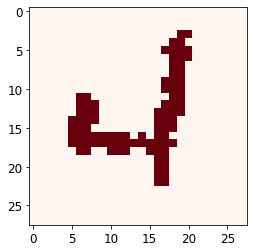

In [0]:
# TESTING
for example in bmnist_data[splits["test"]]:  # Only take a single example
  image = example["image"]
  
  plt.imshow(image.numpy()[:, :, 0].astype(np.float32), cmap=plt.get_cmap("Reds"))

for example in bmnist_data[splits["test"]]:
  image = example["image"]
  test_image = image.numpy()[:, :, 0].astype(np.float32)
 

In [0]:
test_image.shape

(28, 28)

In [0]:
image.shape

TensorShape([28, 28, 1])

In [0]:
test_image

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0

# Input pipelines

In [0]:
bmnist_train = bmnist_train.repeat().shuffle(1024).batch(32)

# prefetch will enable the input pipeline to asynchronously fetch batches while
# your model is training.
bmnist_train = bmnist_train.prefetch(tf.data.experimental.AUTOTUNE)

# Now you could loop over batches of the dataset and train
# for batch in ds_train:
#   ...

bmnist_train


<DatasetV1Adapter shapes: {image: (None, None, 28, 28, 1)}, types: {image: tf.uint8}>

In [0]:
bmnist_test

<DatasetV1Adapter shapes: {image: (28, 28, 1)}, types: {image: tf.uint8}>

<DatasetV1Adapter shapes: {image: (28, 28, 1)}, types: {image: tf.uint8}>

# Visualization


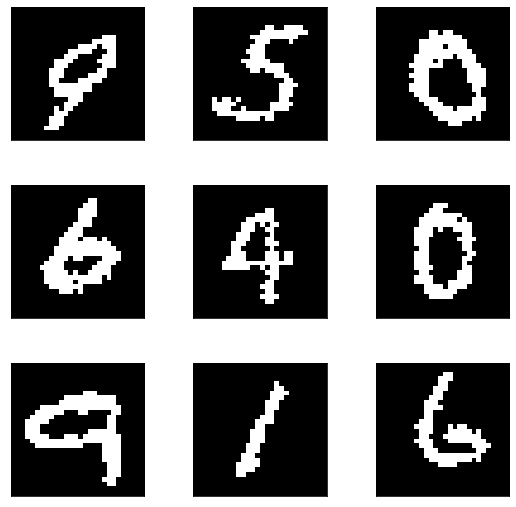

In [0]:
fig = tfds.show_examples(info, bmnist_test)
#fig = tfds.show_examples(info, bmnist_data[splits["test"]])

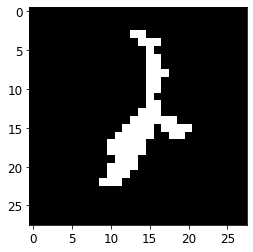

In [0]:
train_example = bmnist_data[splits["train"]].take(1) # taking 1
for sample in train_example:
  image = sample["image"]
  image = image.numpy()[:, :, 0]
  fig = plt.figure
  plt.imshow(image, cmap='gray')
  plt.show()

In [0]:
train_example2 = bmnist_data[splits["train"]] # taking 1
for sample in train_example2:
  image = sample["image"]
  image = image.numpy()[:, :, 0]
  K = range(1, 10)
  meandistortions = []
  inertia= []
  for k in K:
      kmeans = KMeans(n_clusters=k,init='k-means++', random_state=0)
      kmeans.fit(image)

      inertia.append(kmeans.inertia_)

  plt.plot(K, inertia, 'bx-')
  plt.xlabel('k')
  plt.ylabel('inertia')
  plt.title('best K of the model');

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/pytho

KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7f24680b7c80> (for post_execute):


KeyboardInterrupt: ignored

In [0]:
train_example2

<DatasetV1Adapter shapes: {image: (28, 28, 1)}, types: {image: tf.uint8}>

The more clusters there are, the closer each instance will be to its closest centroid, and therefore the lower the inertia will be. However, we can plot the inertia as a function of  k  and analyze the resulting curve:

Another approach is to look at the silhouette score, which is the mean silhouette coefficient over all the instances. An instance's silhouette coefficient is equal to  (b−a)/max(a,b)  where  a  is the mean distance to the other instances in the same cluster (it is the mean intra-cluster distance), and  b  is the mean nearest-cluster distance, that is the mean distance to the instances of the next closest cluster (defined as the one that minimizes  b , excluding the instance's own cluster). The silhouette coefficient can vary between -1 and +1: a coefficient close to +1 means that the instance is well inside its own cluster and far from other clusters, while a coefficient close to 0 means that it is close to a cluster boundary, and finally a coefficient close to -1 means that the instance may have been assigned to the wrong cluster.

In [0]:
from sklearn.metrics import silhouette_score

In [0]:
silhouette_score(bmnist_train.take(1), kmeans.labels_)

ValueError: ignored

In [0]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

Saving figure silhouette_score_vs_k_plot


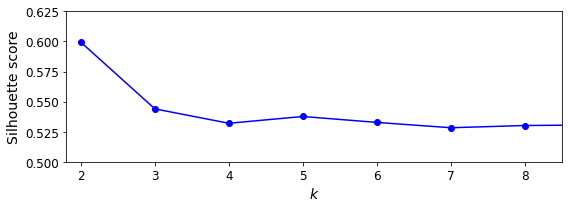

In [0]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.5, 0.625])
save_fig("silhouette_score_vs_k_plot")
plt.show()

Saving figure silhouette_analysis_plot


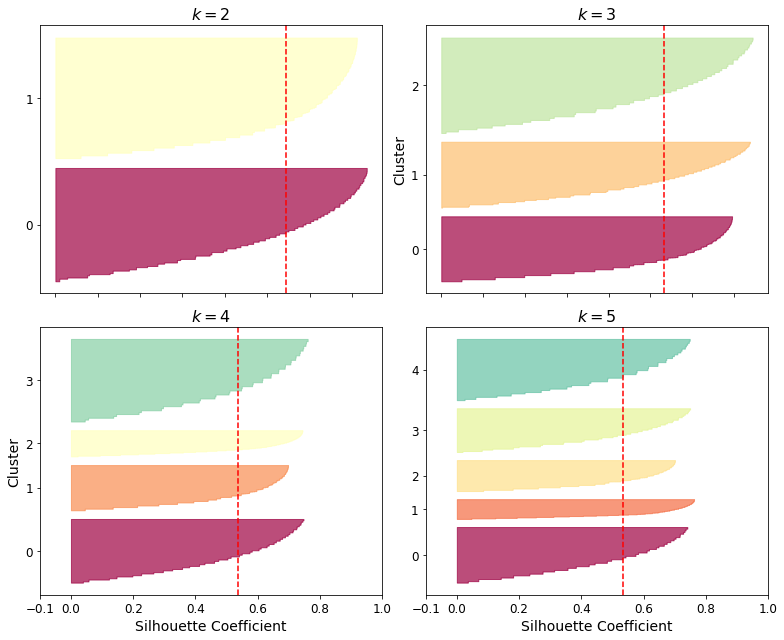

In [0]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (2, 3, 4, 5):
    plt.subplot(2, 2, k - 1)
    
    y_pred = kmeans_per_k[k - 0].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 4):
        plt.ylabel("Cluster")
    
    if k in (4, 5):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 1], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

save_fig("silhouette_analysis_plot")
plt.show()

**PCA using Scikit-Learn**

In [0]:
from sklearn.decomposition import PCA

pca=PCA()
pca.fit(bmnist_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

NameError: ignored